In [20]:
import json
import numpy as np
from pandas.io.json import json_normalize

import os
import glob as gb
import tensorflow as tf

from sklearn.model_selection import train_test_split
import keras 
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM , Flatten , CuDNNLSTM , GRU
from keras.layers import Dropout
import keras

from keras import callbacks
from keras.callbacks import  CSVLogger


# Model Evaluations
from sklearn import metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc


In [21]:
def load_file(filepath,i):
    with open(filepath) as f:
        data = json.load(f)
    imu = data['imu']['data']
    emg = data['emg']['data']
    emg = np.array(emg)
    imu = np.array(imu)
    imu_gyr = np.array([(e['gyroscope']) for e in imu])
    imu_acc = np.array([(e['acceleration']) for e in imu])
    imu_orn = np.array([(e['orientation']) for e in imu])
    #timestamp = [i]
    #timestamp = np.repeat(timestamp, 400, axis=None)
    #timestamp= timestamp.reshape(400,1)
    dataset = tf.concat([emg, imu_gyr, imu_acc, imu_orn], axis=1, name='concat')
    dataset = np.array(dataset)
    return dataset

In [22]:
data_path = '../input/emgimu/An-EMG-and-IMU-Dataset-for-the-Italian-Sign-Language-Alphabet-master/Dataset/'

In [23]:
# For Files Data
X = []
y = []
i=0
for folder in  os.listdir(data_path) : 
    j=0
    files = gb.glob(pathname= str( data_path  + folder + '/*.json'))
    for file in files: 
        data = load_file(file,j)
        X.append(data)
        y.append(i)
        j+=1
    i+=1

print(f'we have {len(X)} items in X ')

we have 780 items in X 


In [24]:
X = np.array(X)
y = np.array(y)

In [25]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=20)


In [26]:
print('X shape is : ' , X.shape)
print('y shape is : ' , y.shape)

X shape is :  (780, 400, 18)
y shape is :  (780,)


In [27]:
mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}

In [28]:
def getcode(n) : 
    for x , y in mapping.items() : 
        if n == y : 
            return x

# Building Model with files

In [29]:
X_train_f, X_split_f, y_train_f, y_split_f = train_test_split(X, y, test_size=0.30, random_state=42)
X_test_f, X_valid_f, y_test_f, y_valid_f = train_test_split(X_split_f, y_split_f, test_size=0.50, random_state=42)

In [30]:
# X_train_f = X_train_f.reshape(X_train_f.shape[0] , X_train_f.shape[1]*X_train_f.shape[2])
# X_valid_f = X_valid_f.reshape(X_valid_f.shape[0] , X_valid_f.shape[1]*X_valid_f.shape[2])
# X_test_f = X_test_f.reshape(X_test_f.shape[0] , X_test_f.shape[1]*X_test_f.shape[2])

X_train_f = X_train_f.reshape(len(X_train_f), X_train_f.shape[1],18)
X_valid_f = X_valid_f.reshape(len(X_test_f), X_test_f.shape[1],18)
X_test_f = X_test_f.reshape(len(X_valid_f), X_valid_f.shape[1],18)

In [31]:
print(X_train_f.shape)
print(X_test_f.shape)

(546, 400, 18)
(117, 400, 18)


In [32]:
y_train_f = to_categorical(y_train_f)
y_test_f=to_categorical(y_test_f)
y_valid_f=to_categorical(y_valid_f)

In [51]:
model = keras.models.Sequential([
        keras.layers.Conv1D(256, 3, activation='relu', input_shape =(400,18)),
        keras.layers.MaxPooling1D(3),
        keras.layers.Conv1D(128, 3, activation='relu'),
        keras.layers.MaxPooling1D(3),
        keras.layers.Conv1D(64, 3, activation='relu'),
        keras.layers.MaxPooling1D(3),
        keras.layers.Flatten(),
#         keras.layers.Dense(256,activation='relu' ) ,    
        keras.layers.Dense(128,activation='relu') ,    
#         keras.layers.Dense(64,activation='relu') ,  
        keras.layers.Dense(26,activation='softmax') ,    
        ])
# 


In [52]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 398, 256)          14080     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 132, 256)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 130, 128)          98432     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 43, 128)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 41, 64)            24640     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 13, 64)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 832)              

In [53]:
import tensorflow as tf

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="./checkpoint-{epoch:02d}.hdf5", verbose=1, save_best_only=True, monitor='val_acc',mode='max')
csv_logger = CSVLogger('training_set_iranalysis3.csv',separator=',', append=False)
history = model.fit(X_train_f, y_train_f, batch_size=128, epochs=100, validation_data=(X_valid_f, y_valid_f),callbacks=[es,checkpointer,csv_logger])
model.save("./lstm.hdf5")

Epoch 1/100
5/5 [==============================] - 2s 285ms/step - loss: 10.6054 - accuracy: 0.0348 - val_loss: 5.7286 - val_accuracy: 0.0684
Epoch 2/100
5/5 [==============================] - 1s 221ms/step - loss: 4.3126 - accuracy: 0.0824 - val_loss: 3.3267 - val_accuracy: 0.0684
Epoch 3/100
5/5 [==============================] - 1s 225ms/step - loss: 3.1288 - accuracy: 0.1136 - val_loss: 3.0292 - val_accuracy: 0.1111
Epoch 4/100
5/5 [==============================] - 1s 222ms/step - loss: 2.7359 - accuracy: 0.2418 - val_loss: 2.9200 - val_accuracy: 0.1795
Epoch 5/100
5/5 [==============================] - 1s 221ms/step - loss: 2.3704 - accuracy: 0.3626 - val_loss: 2.5825 - val_accuracy: 0.2051
Epoch 6/100
5/5 [==============================] - 1s 222ms/step - loss: 1.9388 - accuracy: 0.4560 - val_loss: 2.1592 - val_accuracy: 0.3077
Epoch 7/100
5/5 [==============================] - 1s 226ms/step - loss: 1.4786 - accuracy: 0.5751 - val_loss: 1.8989 - val_accuracy: 0.4103
Epoch 8/100


In [54]:
test_results = model.evaluate(X_test_f, y_test_f, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

4/4 [==============================] - 0s 21ms/step - loss: 1.0667 - accuracy: 0.8205
Test results - Loss: 1.0666824579238892 - Accuracy: 82.05128312110901%


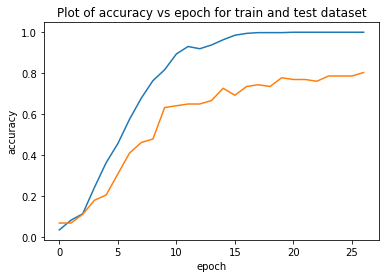

In [55]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Plot of accuracy vs epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

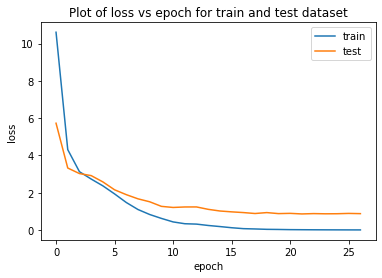

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()